In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale = 13e-6
psf_pixelscale_m = 13e-6*u.m/u.pix
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

disk_pixelscale_mas = 10.5*u.mas/u.pix
disk_pixelscale_lamD = disk_pixelscale_mas.value / mas_per_lamD.value

iwa = 3
owa = 9

# Load PSFs

In [2]:
psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20221006.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))

(3331, 64, 64) 3331


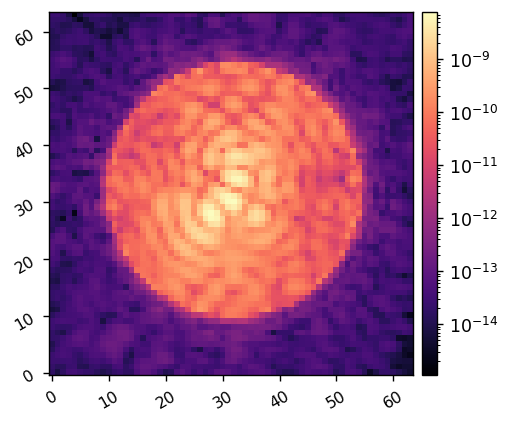

In [3]:
for psf in psfs:
    try:
        misc.myimshow(psf, lognorm=True)
        clear_output(wait=True)
        time.sleep(0.1)
    except KeyboardInterrupt: 
        break

In [4]:
r_offsets[0]

NameError: name 'r_offsets' is not defined

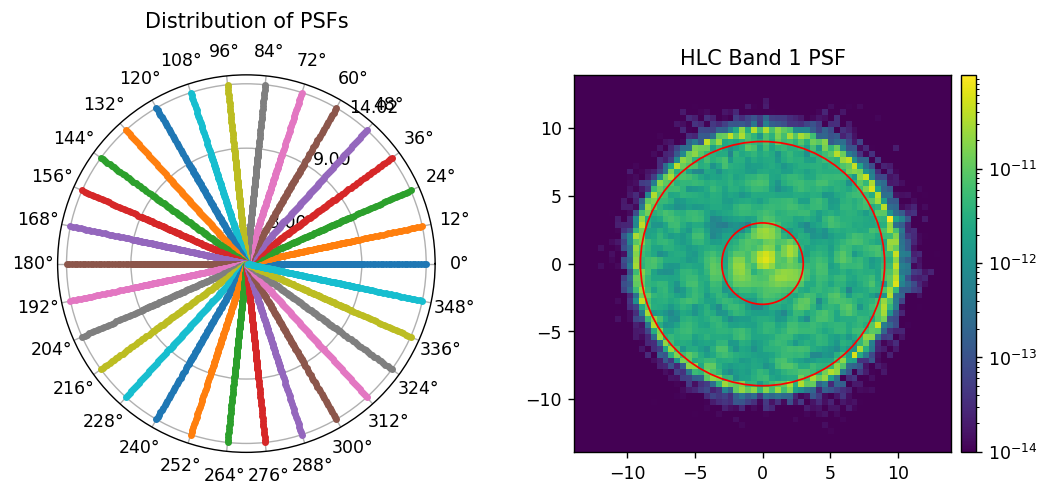

In [5]:
r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20221006.fits'
thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20221006.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(10,4))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.')
ax1.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax1.set_thetagrids(thetas.value)
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.grid(True)
ax1.set_title('Distribution of PSFs', va='bottom')

ax2 = plt.subplot(122)
ext = [-psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2,
       -psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2]
im = ax2.imshow(psfs[0], norm=LogNorm(vmin=psfs[0].max()/1e4), cmap='viridis', extent=ext)
ax2.add_patch(Circle((0, 0), iwa, color='r', fill=False))
ax2.add_patch(Circle((0, 0), owa, color='r', fill=False))
ax2.set_title('HLC Band 1 PSF')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.075)
fig.colorbar(im, cax=cax)

# Setup/Test the interpolating function

In [6]:
r_offsets_mas = r_offsets * mas_per_lamD

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     if kr>(len(r_offsets)-1):
#         kr = len(r_offsets)-1
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: 
#         kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
#     return interpped_psf

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=0)
    
    return interpped_psf

In [44]:
20.8*(5*npsf//7 - npsf//2)

270.40000000000003

Desired r=270.00 mas, radial index=52, closest available r=269.01 mas
Desired th=118.00 deg, theta index=10, closest available th=120.00 deg, difference=-2.00 deg
PSF index = 1541


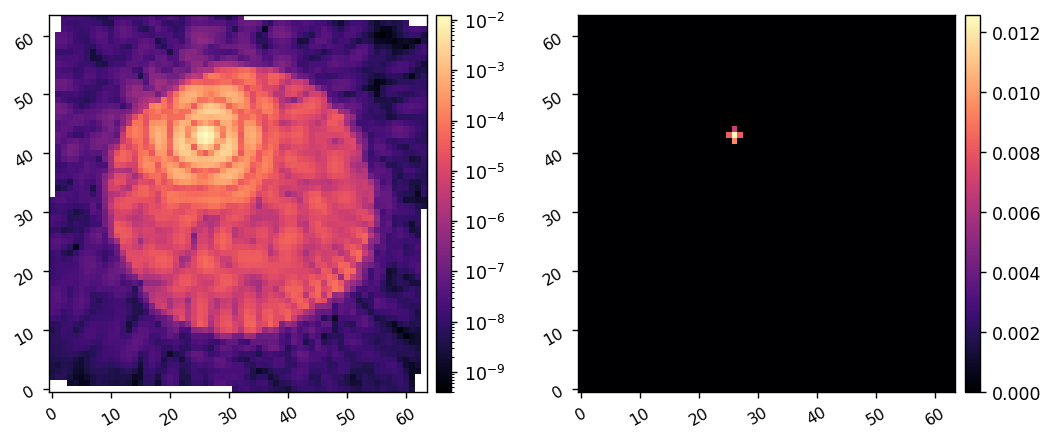

0.04544474696053912

In [13]:
r = 270*u.mas
th = 118*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

mask = (psf>psf.max()/2)

misc.myimshow2(psf, mask*psf, lognorm1=True)
np.sum(mask*psf)

# Create the grid for which the interpolated PSFs will be calculated

In [8]:
ndisk = 127
disk_pixelscale_mas = 10.5*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-661.5, -651. , -640.5, ...,  640.5,  651. ,  661.5] mas>

Desired r=935.50 mas, radial index=111, closest available r=703.70 mas
Desired th=225.00 deg, theta index=19, closest available th=228.00 deg, difference=-3.00 deg
PSF index = 3320


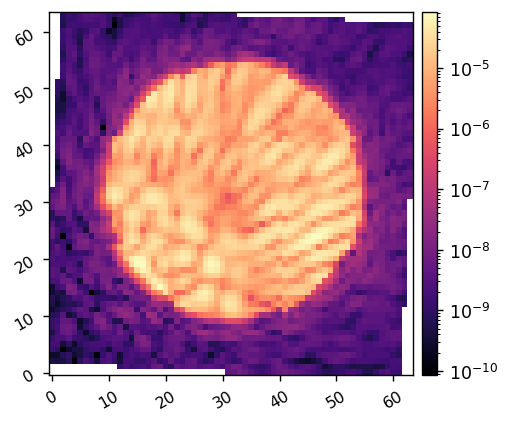

In [14]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [15]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

16128 9.373579263687134


In [16]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()